# Step 1 — RGB to HSV and Red Mask

In [51]:
import numpy as np

# ------------------------------------------------------------
# LOW-LEVEL STEP 1 (single image): RGB->HSV (uint8) + red mask
# ------------------------------------------------------------

def rgb_to_hsv_u8_pixel(R, G, B):
    """
    Convert one RGB pixel (0..255) to HSV in uint8 (0..255).
    Returns: (H, S, V) each in 0..255.
    
    Notes:
      - Integer approximation (HW-friendly).
      - Hue scaled to 0..255 representing 0..360 degrees.
    """
    # Find max/min among channels
    mx = R
    if G > mx: mx = G
    if B > mx: mx = B

    mn = R
    if G < mn: mn = G
    if B < mn: mn = B

    delta = mx - mn

    # Value is max channel
    V = mx

    # If black pixel => saturation=0, hue=0
    if mx == 0:
        return 0, 0, V

    # Saturation in 0..255
    S = (delta * 255) // mx

    # If gray pixel (no chroma) => hue=0
    if delta == 0:
        return 0, S, V

    # Hue in 0..255 (approx)
    # 43 ~= 256/6
    if mx == R:
        h = (43 * (G - B)) // delta
        if h < 0:
            h += 256
    elif mx == G:
        h = 85 + (43 * (B - R)) // delta
    else:
        h = 171 + (43 * (R - G)) // delta

    H = h & 0xFF
    return H, S, V


def red_mask_lowlevel_single(
    img_rgb_u8,
    hue_low1=0, hue_high1=10,
    hue_low2=245, hue_high2=255,
    sat_thresh_u8=64,   # ~0.25*255
    val_thresh_u8=64    # ~0.25*255
):
    """
    Create a red mask for ONE image.
    Input:
      img_rgb_u8: HxWx3 uint8
    Output:
      mask: HxW uint8 values {0,1}
    """
    H, W, C = img_rgb_u8.shape
    if C != 3:
        raise ValueError("Expected RGB image with 3 channels (HxWx3).")

    mask = np.zeros((H, W), dtype=np.uint8)

    for y in range(H):
        for x in range(W):
            # Read pixel as Python ints to avoid uint8 arithmetic issues
            R = int(img_rgb_u8[y, x, 0])
            G = int(img_rgb_u8[y, x, 1])
            B = int(img_rgb_u8[y, x, 2])

            # Convert RGB->HSV (uint8 domain)
            h, s, v = rgb_to_hsv_u8_pixel(R, G, B)

            # Red hue wrap-around check
            hue_ok = ((hue_low1 <= h <= hue_high1) or (hue_low2 <= h <= hue_high2))

            # Saturation/value thresholds
            sat_ok = (s >= sat_thresh_u8)
            val_ok = (v >= val_thresh_u8)

            # Final decision
            mask[y, x] = 1 if (hue_ok and sat_ok and val_ok) else 0

    return mask


# ------------------------------------------------------------
# LOW-LEVEL STEP 1 (batch): loop outside
# ------------------------------------------------------------

def step1_red_masks_batch(images_rgb_u8, **kwargs):
    """
    Run Step 1 on a LIST of RGB images.
    images_rgb_u8: list of HxWx3 uint8 images
    kwargs: forwarded to red_mask_lowlevel_single (thresholds, etc.)
    Returns: list of HxW uint8 masks
    """
    masks = []
    for img in images_rgb_u8:
        masks.append(red_mask_lowlevel_single(img, **kwargs))
    return masks


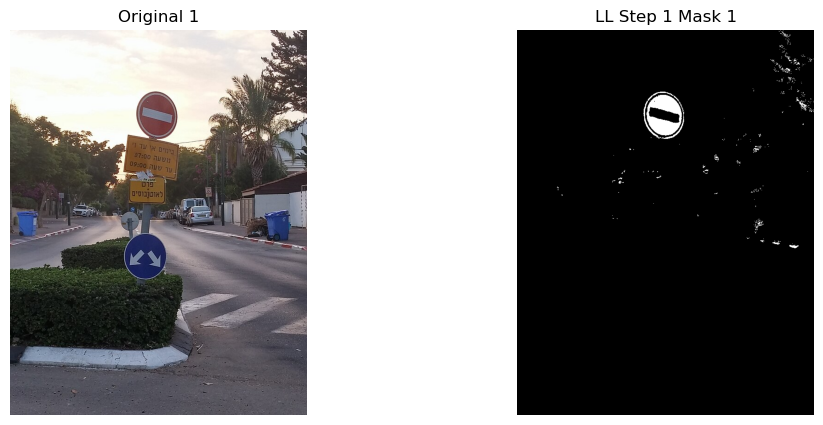

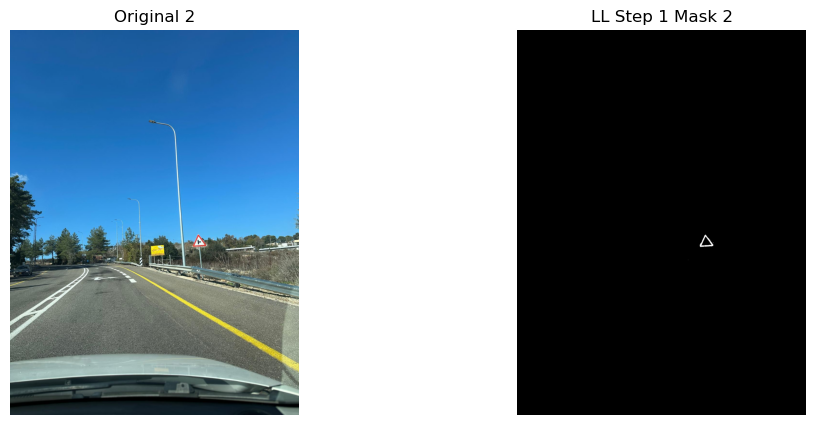

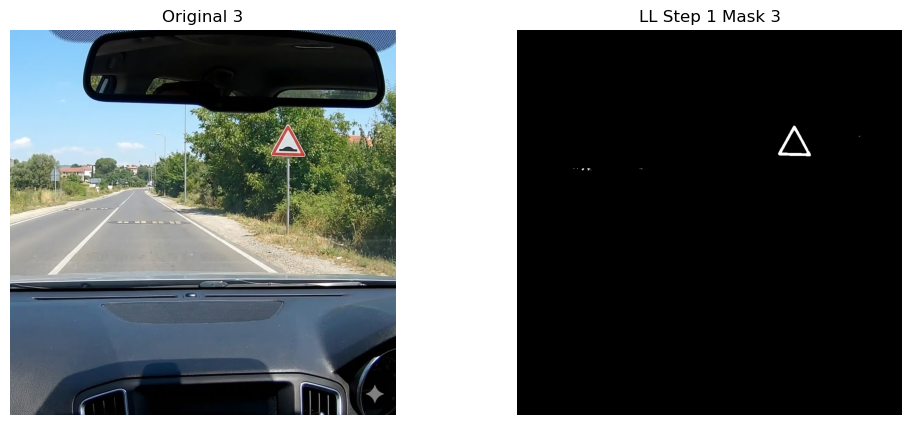

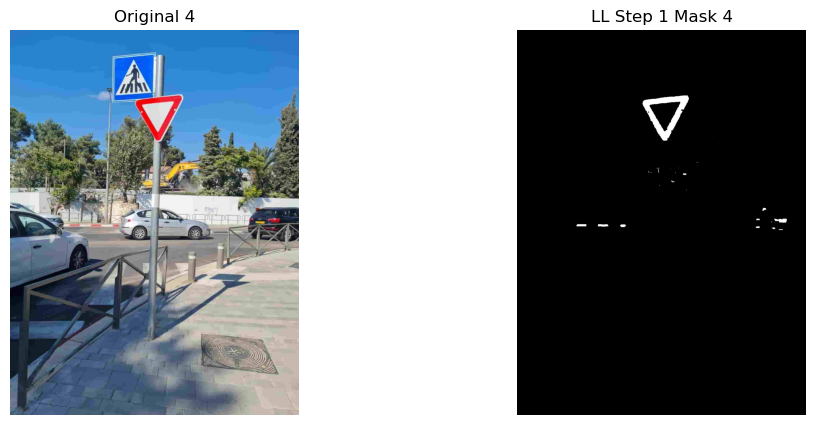

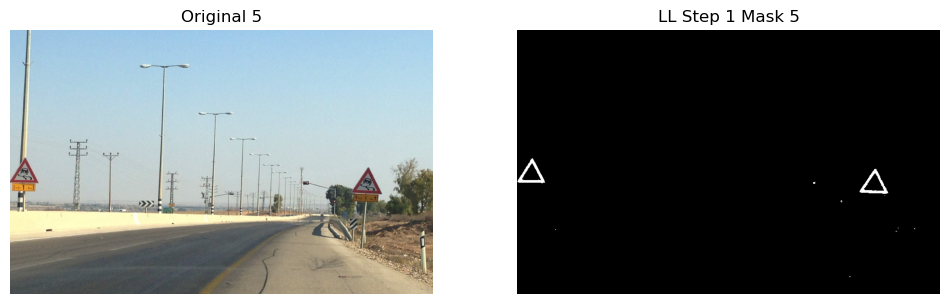

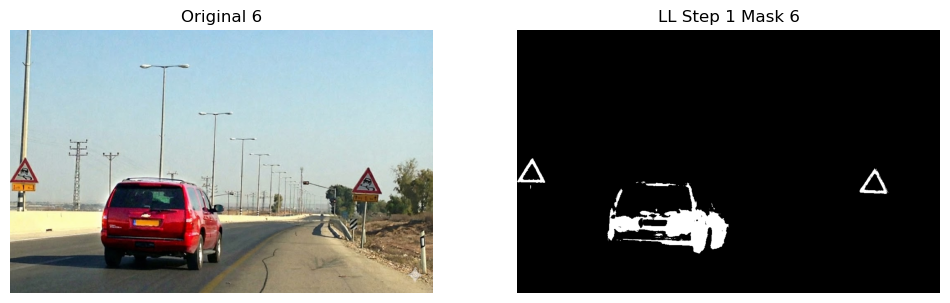

In [52]:
# ------------------------------------------------------------
# Load images from a directory (minimal, explicit)
# ------------------------------------------------------------

import os
from skimage import io

IMAGE_DIR = "real_pictures"

images = []

for fname in sorted(os.listdir(IMAGE_DIR)):
    if fname.lower().endswith((".jpg", ".jpeg", ".png")):
        img = io.imread(os.path.join(IMAGE_DIR, fname))

        # Ensure RGB uint8
        if img.ndim == 2:  # grayscale -> RGB
            img = np.stack([img, img, img], axis=2)
        if img.shape[2] == 4:  # RGBA -> RGB
            img = img[:, :, :3]
        if img.dtype != np.uint8:
            img = img.astype(np.uint8)

        images.append(img)

masks_ll = step1_red_masks_batch(images)

# Quick visualization
import matplotlib.pyplot as plt
for i, (img, m) in enumerate(zip(images, masks_ll), start=1):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1); plt.imshow(img); plt.title(f"Original {i}"); plt.axis("off")
    plt.subplot(1, 2, 2); plt.imshow(m, cmap="gray"); plt.title(f"LL Step 1 Mask {i}"); plt.axis("off")
    plt.show()


# Step 2 (single mask): morphology (closing) + optional hole filling

In [53]:

# ------------------------------------------------------------
# Step 2 (single mask): morphology (closing) + optional hole filling
# ------------------------------------------------------------

import numpy as np
from collections import deque

# ------------------------------------------------------------
# Helpers: disk footprint (matches skimage.morphology.disk behavior)
# ------------------------------------------------------------

def make_disk_offsets(radius):
    """
    Create (dy,dx) offsets for a flat disk footprint:
    dy^2 + dx^2 <= radius^2
    """
    offs = []
    r2 = radius * radius
    for dy in range(-radius, radius + 1):
        for dx in range(-radius, radius + 1):
            if dy*dy + dx*dx <= r2:
                offs.append((dy, dx))
    return offs


# ------------------------------------------------------------
# Binary morphology with disk footprint (0/1 masks)
# ------------------------------------------------------------

def binary_dilate_disk_single(mask_u8, radius):
    """
    Binary dilation using a disk footprint.
    Output pixel is 1 if ANY neighbor under the disk is 1.
    Outside-image pixels are treated as 0.
    """
    H, W = mask_u8.shape
    out = np.zeros((H, W), dtype=np.uint8)
    offs = make_disk_offsets(radius)

    for y in range(H):
        for x in range(W):
            val = 0
            for dy, dx in offs:
                yy = y + dy
                xx = x + dx
                if 0 <= yy < H and 0 <= xx < W:
                    if mask_u8[yy, xx] != 0:
                        val = 1
                        break
            out[y, x] = val

    return out


def binary_erode_disk_single(mask_u8, radius):
    """
    Binary erosion using a disk footprint.
    Output pixel is 1 only if ALL neighbors under the disk are 1.
    Outside-image pixels are treated as 0 (so erosion near borders tends to shrink).
    """
    H, W = mask_u8.shape
    out = np.zeros((H, W), dtype=np.uint8)
    offs = make_disk_offsets(radius)

    for y in range(H):
        for x in range(W):
            val = 1
            for dy, dx in offs:
                yy = y + dy
                xx = x + dx
                if not (0 <= yy < H and 0 <= xx < W):
                    val = 0
                    break
                if mask_u8[yy, xx] == 0:
                    val = 0
                    break
            out[y, x] = val

    return out


def binary_close_disk_single(mask_u8, radius):
    """
    Closing = dilation followed by erosion (same disk radius).
    Matches the structure of:
      closed = erosion(dilation(mask, disk(r)), disk(r))
    """
    dil = binary_dilate_disk_single(mask_u8, radius)
    clo = binary_erode_disk_single(dil, radius)
    return clo


# ------------------------------------------------------------
# Connected components (low-level BFS) with pixel collection
# ------------------------------------------------------------

def collect_components(mask_u8, target_value=1):
    """
    Collect connected components for pixels == target_value using 4-connectivity.
    Returns a list of components, each component is:
      {
        "area": int,
        "touches_border": bool,
        "pixels": list of linear indices (y*W + x)
      }
    """
    H, W = mask_u8.shape
    visited = np.zeros((H, W), dtype=np.uint8)
    comps = []

    # 4-neighbors only
    nbrs = [(-1,0),(1,0),(0,-1),(0,1)]

    for y0 in range(H):
        for x0 in range(W):
            if mask_u8[y0, x0] != target_value or visited[y0, x0] != 0:
                continue

            q = deque()
            q.append((y0, x0))
            visited[y0, x0] = 1

            pixels = []
            area = 0
            touches_border = False

            while q:
                y, x = q.popleft()
                area += 1
                pixels.append(y * W + x)

                if y == 0 or x == 0 or y == H-1 or x == W-1:
                    touches_border = True

                for dy, dx in nbrs:
                    yy = y + dy
                    xx = x + dx
                    if 0 <= yy < H and 0 <= xx < W:
                        if visited[yy, xx] == 0 and mask_u8[yy, xx] == target_value:
                            visited[yy, xx] = 1
                            q.append((yy, xx))

            comps.append({
                "area": area,
                "touches_border": touches_border,
                "pixels": pixels
            })

    return comps


# ------------------------------------------------------------
# High-level-equivalent hole filling and small-foreground removal
# ------------------------------------------------------------

def fill_enclosed_holes_like_highlevel(mask_u8, min_hole_size=300):
    """
    Mimics the high-level approach with 4-connectivity:
      inv = 1 - mask
      label inv-components (holes/background)
      fill only components that:
        - do NOT touch border
        - area >= min_hole_size
    """
    H, W = mask_u8.shape
    inv = (1 - mask_u8).astype(np.uint8)

    comps = collect_components(inv, target_value=1)
    filled = mask_u8.copy()

    for comp in comps:
        if comp["touches_border"]:
            continue
        if comp["area"] < min_hole_size:
            continue

        # Fill this enclosed hole
        for idx in comp["pixels"]:
            y = idx // W
            x = idx % W
            filled[y, x] = 1

    return filled


def remove_small_foreground_like_highlevel(mask_u8, min_foreground_size=1000):
    """
    Mimics the high-level approach with 4-connectivity:
      label foreground components and delete those with area < min_foreground_size
    """
    H, W = mask_u8.shape
    comps = collect_components(mask_u8, target_value=1)
    out = mask_u8.copy()

    for comp in comps:
        if comp["area"] < min_foreground_size:
            for idx in comp["pixels"]:
                y = idx // W
                x = idx % W
                out[y, x] = 0

    return out



# ------------------------------------------------------------
# Union-Find Connected-Component Labeling (HW-friendly)
# ------------------------------------------------------------

def uf_find(parent: np.ndarray, x: int) -> int:
    """Find with path compression (iterative)."""
    while parent[x] != x:
        parent[x] = parent[parent[x]]
        x = parent[x]
    return int(x)

def uf_union(parent: np.ndarray, a: int, b: int) -> int:
    """Union by smaller root id (deterministic). Returns root."""
    ra = uf_find(parent, int(a))
    rb = uf_find(parent, int(b))
    if ra == rb:
        return ra
    if ra < rb:
        parent[rb] = ra
        return ra
    else:
        parent[ra] = rb
        return rb


def ccl_pass1_unionfind(mask_u8: np.ndarray,
                        target_value: int = 1,
                        max_labels: int = 4096):
    """
    Pass 1: raster scan labeling + equivalence recording (Union-Find).
    Assumes 4-connectivity (left, up neighbors only).
    Returns: label_img, parent, next_label
    """
    H, W = mask_u8.shape
    label_img = np.zeros((H, W), dtype=np.uint32)

    # Union-find parent table. parent[0] unused.
    parent = np.arange(max_labels + 1, dtype=np.uint32)

    next_label = 1  # labels start at 1

    for y in range(H):
        for x in range(W):
            if mask_u8[y, x] != target_value:
                continue

            # Raster-scan neighbors: left, up
            left = int(label_img[y, x - 1]) if x > 0 else 0
            up   = int(label_img[y - 1, x]) if y > 0 else 0

            neighs = (left, up)

            # Keep only non-zero labels
            m = 0
            for v in neighs:
                if v != 0 and (m == 0 or v < m):
                    m = v

            if m == 0:
                # New component label
                if next_label > max_labels:
                    raise RuntimeError(
                        f"Exceeded max_labels={max_labels}. Increase max_labels or improve preprocessing."
                    )
                label_img[y, x] = next_label
                parent[next_label] = next_label
                next_label += 1
            else:
                # Assign min label, union with any other neighbor labels
                label_img[y, x] = m
                for v in neighs:
                    if v != 0 and v != m:
                        uf_union(parent, m, v)

    return label_img, parent, next_label


def ccl_pass2_stats(label_img: np.ndarray,
                    parent: np.ndarray,
                    next_label: int):
    """
    Pass 2: resolve roots and accumulate stats per root label.
    We accumulate:
      area[root]         = number of pixels in component
      touch_border[root] = 1 if any pixel touches image border

    Returns:
      area:     uint32 [next_label] (index 0 unused)
      touch:    uint8  [next_label]
    """
    H, W = label_img.shape
    area = np.zeros(next_label, dtype=np.uint32)
    touch = np.zeros(next_label, dtype=np.uint8)

    # Compress all parents once for stability
    for lbl in range(1, next_label):
        parent[lbl] = uf_find(parent, int(lbl))

    for y in range(H):
        is_border_y = (y == 0 or y == H - 1)
        for x in range(W):
            lbl = int(label_img[y, x])
            if lbl == 0:
                continue
            r = int(parent[lbl])
            area[r] += 1
            if is_border_y or (x == 0 or x == W - 1):
                touch[r] = 1

    return area, touch


def remove_small_foreground_by_ccl(mask_u8: np.ndarray,
                                  min_foreground_size: int,
                                  max_labels: int = 4096) -> np.ndarray:
    """
    Label foreground components and delete those with area < threshold. Uses 4-connectivity.
    """
    label_img, parent, next_label = ccl_pass1_unionfind(
        mask_u8, target_value=1, max_labels=max_labels
    )
    area, _touch = ccl_pass2_stats(label_img, parent, next_label)

    H, W = mask_u8.shape
    out = mask_u8.copy()

    for y in range(H):
        for x in range(W):
            lbl = int(label_img[y, x])
            if lbl == 0:
                continue
            r = int(parent[lbl])
            if area[r] < min_foreground_size:
                out[y, x] = 0

    return out


def fill_holes_by_ccl(mask_u8: np.ndarray,
                      min_hole_size: int,
                      max_labels: int = 4096) -> np.ndarray:
    """
    Fill enclosed holes using 4-connectivity:
      inv = 1 - mask
      find connected components in inv (background)
      fill those that do NOT touch border and have area >= min_hole_size
    """
    inv = (1 - mask_u8).astype(np.uint8)

    bg_label_img, bg_parent, bg_next_label = ccl_pass1_unionfind(
        inv, target_value=1, max_labels=max_labels
    )
    bg_area, bg_touch = ccl_pass2_stats(bg_label_img, bg_parent, bg_next_label)

    H, W = mask_u8.shape
    filled = mask_u8.copy()

    for y in range(H):
        for x in range(W):
            lbl = int(bg_label_img[y, x])
            if lbl == 0:
                continue  # not background
            r = int(bg_parent[lbl])
            if bg_touch[r] == 0 and bg_area[r] >= min_hole_size:
                filled[y, x] = 1

    return filled


def solidify_like_hardware(mask_u8: np.ndarray,
                           min_hole_size: int = 300,
                           min_foreground_size: int = 1000,
                           max_labels: int = 4096) -> np.ndarray:
    """
    Full low-level postprocessing assuming closing already done (4-connectivity):
      1) fill holes (size-filtered)
      2) remove small foreground components
    """
    filled = fill_holes_by_ccl(
        mask_u8, min_hole_size=min_hole_size, max_labels=max_labels
    )
    cleaned = remove_small_foreground_by_ccl(
        filled, min_foreground_size=min_foreground_size, max_labels=max_labels
    )
    return cleaned


def solidify_mask_lowlevel_single(mask_u8,
                                 close_radius=3,
                                 min_hole_size=300,
                                 min_foreground_size=1000,
                                 smooth_radius=0,
                                 max_labels=4096):
    """
    Low-level equivalent of your high-level 'solidify_mask':
      1) closing with disk(close_radius)
      2) fill enclosed holes (min_hole_size) using union-find CCL
      3) remove small foreground components (min_foreground_size) using union-find CCL
      4) optional smoothing closing with disk(smooth_radius)

    Always uses the union-find CCL backend (no BFS path).
    """
    # 1) Closing (disk)
    closed = binary_close_disk_single(mask_u8, radius=close_radius)

    # 2) Fill holes (size-filtered) - unionfind CCL
    filled = fill_holes_by_ccl(
        closed, min_hole_size=min_hole_size, max_labels=max_labels
    )

    # 3) Remove small foreground components - unionfind CCL
    cleaned = remove_small_foreground_by_ccl(
        filled, min_foreground_size=min_foreground_size, max_labels=max_labels
    )

    # 4) Optional smoothing (same style closing)
    if smooth_radius and smooth_radius > 0:
        cleaned = binary_close_disk_single(cleaned, radius=smooth_radius)

    return cleaned



def solidify_mask_lowlevel_batch(masks_u8, **kwargs):
    """
    Batch wrapper: run solidify_mask_lowlevel_single on a list of masks.
    Pass-through kwargs include:
      close_radius, min_hole_size, min_foreground_size, smooth_radius, max_labels

    Note: always uses union-find CCL (no BFS backend).
    """
    out = []
    for m in masks_u8:
        out.append(solidify_mask_lowlevel_single(m, **kwargs))
    return out



Image 1: step1 ones=6124, step2 ones=7012
Image 2: step1 ones=860, step2 ones=1652
Image 3: step1 ones=1906, step2 ones=3931
Image 4: step1 ones=14583, step2 ones=20558
Image 5: step1 ones=1455, step2 ones=2697
Showing 6 images...


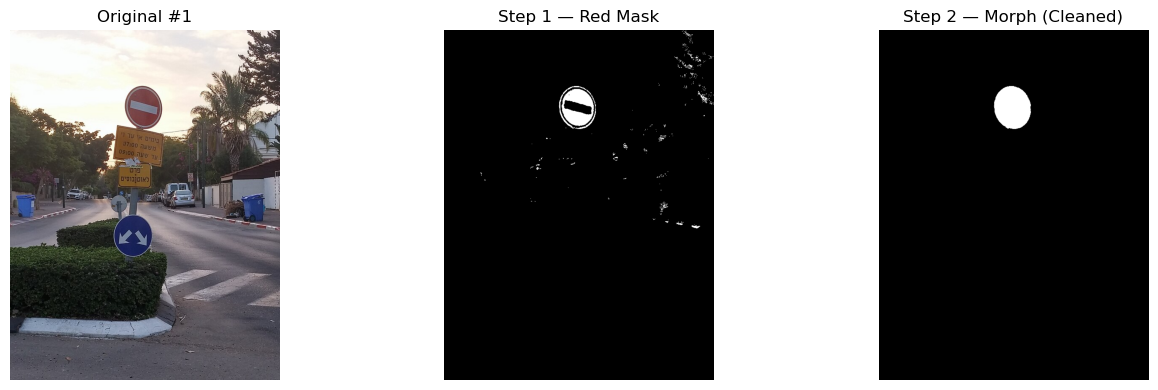

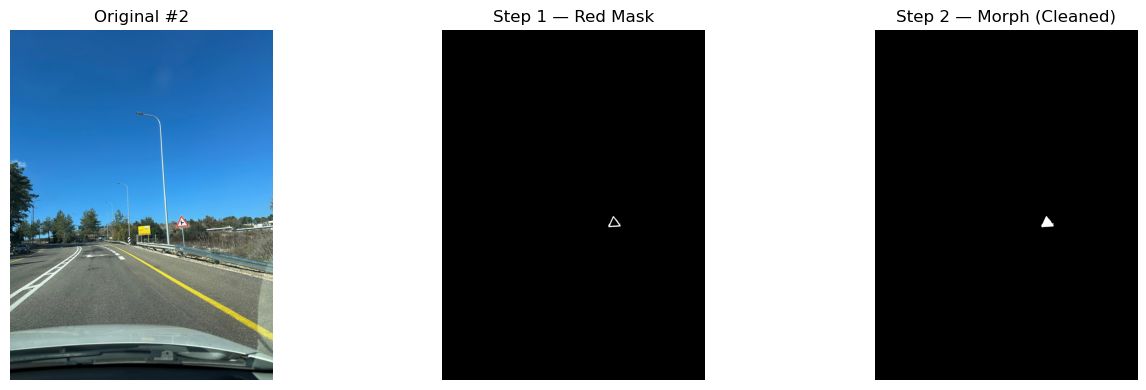

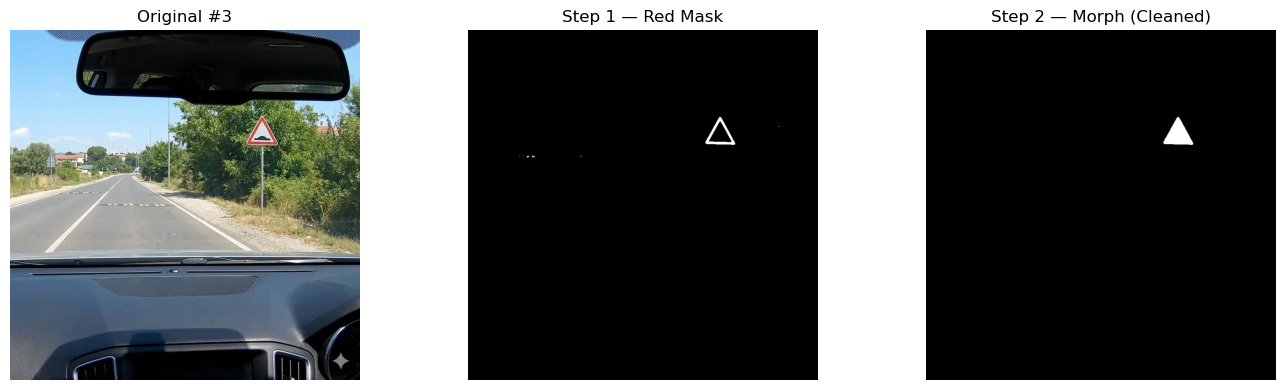

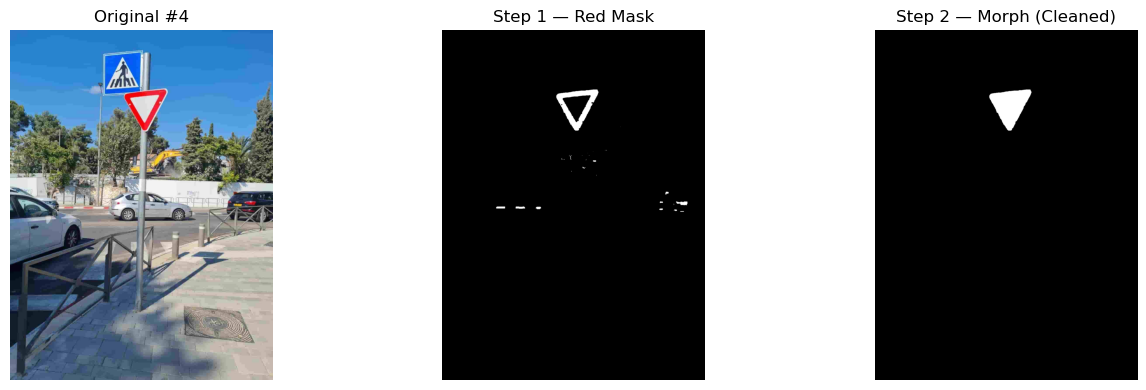

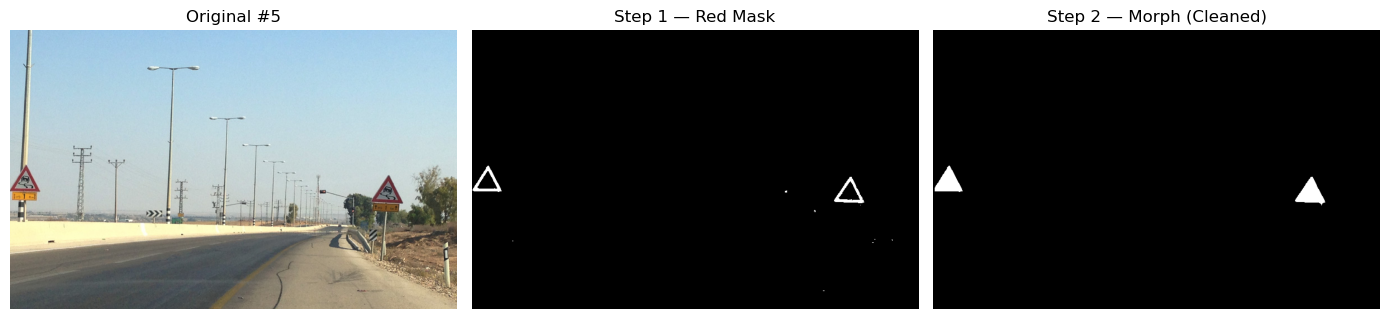

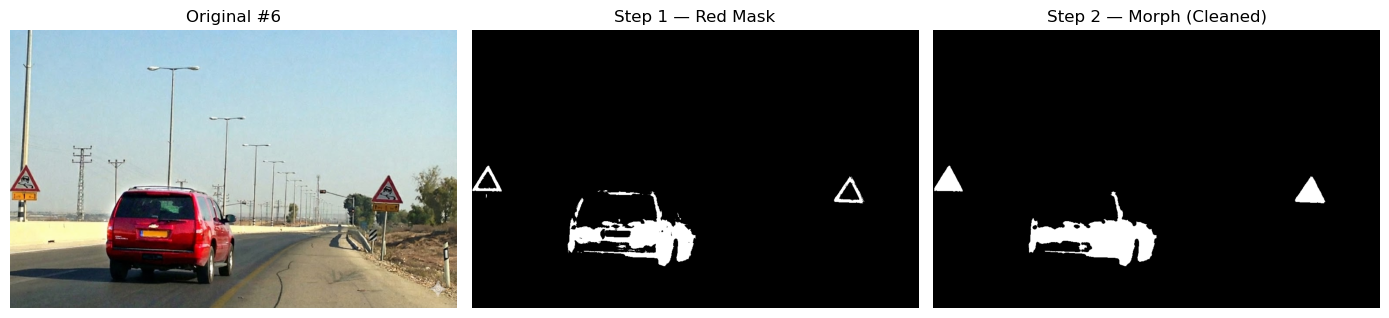

In [54]:
# ------------------------------------------------------------
# Visualization
# ------------------------------------------------------------

def show_step1_and_step2(images, masks_step1, masks_step2, max_show=None):
    """
    Display per image:
      - Original RGB
      - Step 1 mask (0/1)
      - Step 2 mask (0/1)
    """
    n = len(images)
    if max_show is not None:
        n = min(n, max_show)

    print(f"Showing {n} images...")  # sanity print

    for i in range(n):
        img = images[i]
        m1 = masks_step1[i]
        m2 = masks_step2[i]

        plt.figure(figsize=(14, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title(f"Original #{i+1}")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(m1, cmap="gray", vmin=0, vmax=1)
        plt.title("Step 1 — Red Mask")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(m2, cmap="gray", vmin=0, vmax=1)
        plt.title("Step 2 — Morph (Cleaned)")
        plt.axis("off")

        plt.tight_layout()
        plt.show()


# ------------------------------------------------------------
# RUN (edit IMAGE_DIR if needed)
# ------------------------------------------------------------


masks_step1 = step1_red_masks_batch(images)

# Step 2 (HIGHLEVEL-like): closing(disk) + fill enclosed holes + remove small FG
masks_step2 = solidify_mask_lowlevel_batch(
    masks_step1,
    close_radius=3,
    min_hole_size=300,
    min_foreground_size=1000,
    smooth_radius=0
)
# Optional sanity stats (helps see if noise is being removed)
for i in range(min(5, len(masks_step1))):
    s1 = int(masks_step1[i].sum())
    s2 = int(masks_step2[i].sum())
    print(f"Image {i+1}: step1 ones={s1}, step2 ones={s2}")

# Display
show_step1_and_step2(images, masks_step1, masks_step2, max_show=10)


# Step 3 — Connected Components + Shape Metrics + Best ROI selection

Showing 6 images...
Image 1: shape=circle area=7012 per=270 circ=1.209 bbox=(133, 272, 234, 359)


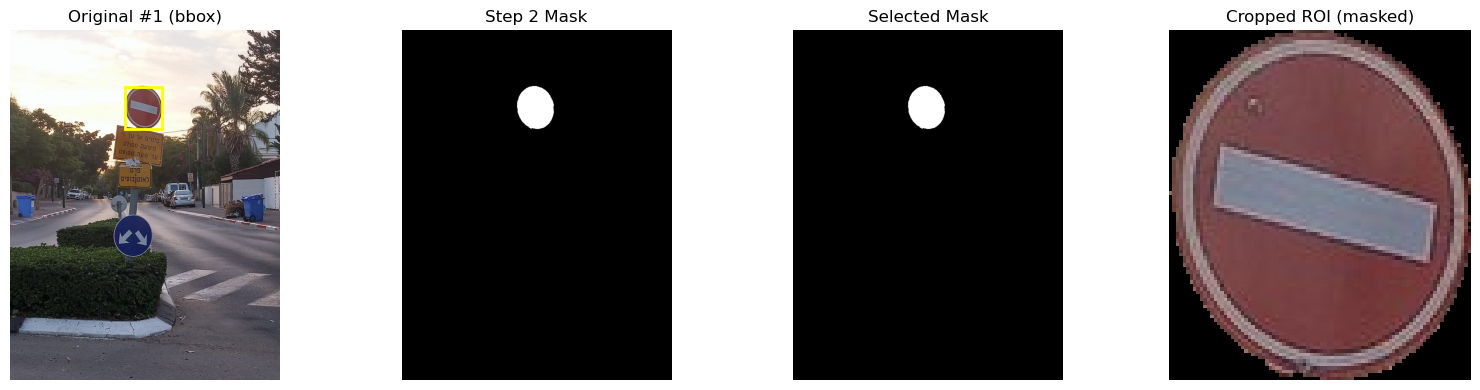

Image 2: shape=triangle area=1652 per=162 circ=0.791 bbox=(850, 759, 901, 815)


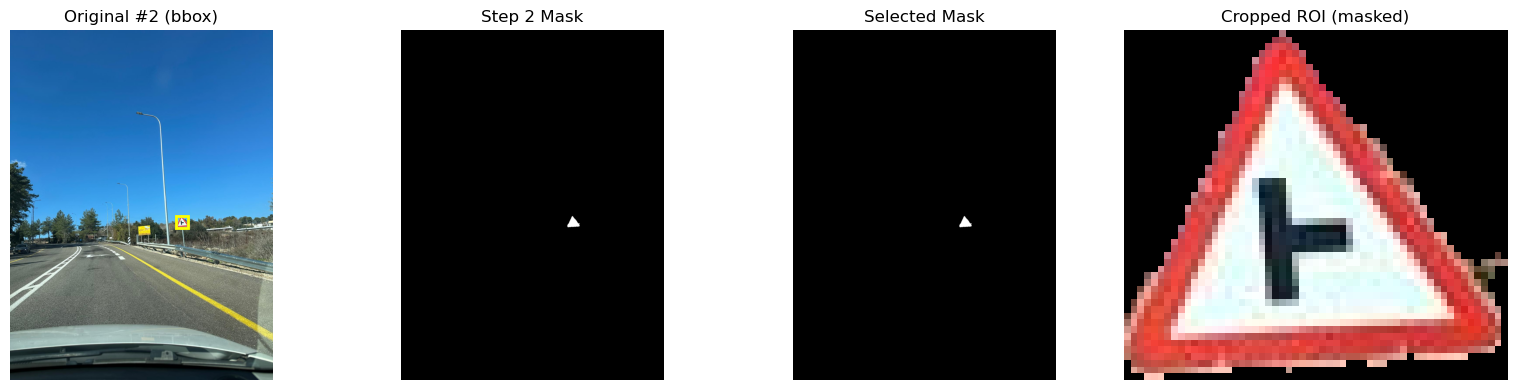

Image 3: shape=triangle area=3931 per=244 circ=0.830 bbox=(254, 694, 335, 781)


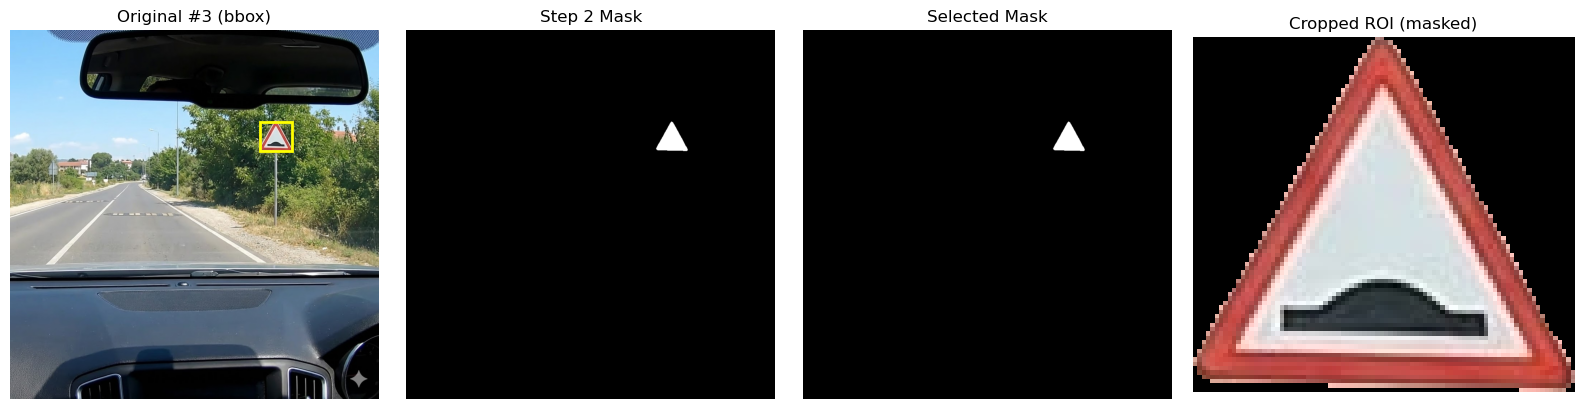

Image 4: shape=triangle area=20558 per=566 circ=0.806 bbox=(272, 521, 459, 713)


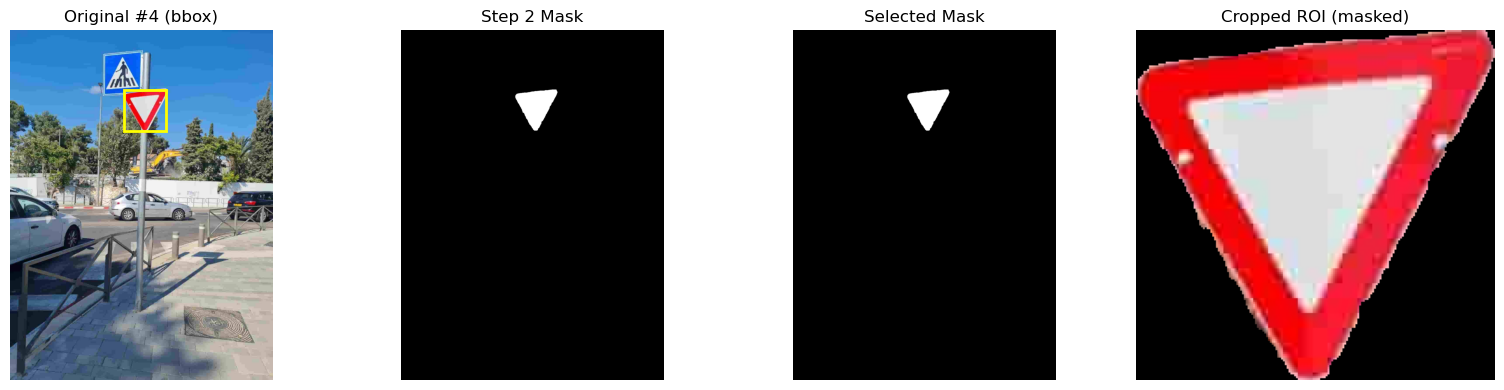

Image 5: shape=triangle area=1393 per=146 circ=0.821 bbox=(264, 648, 314, 701)


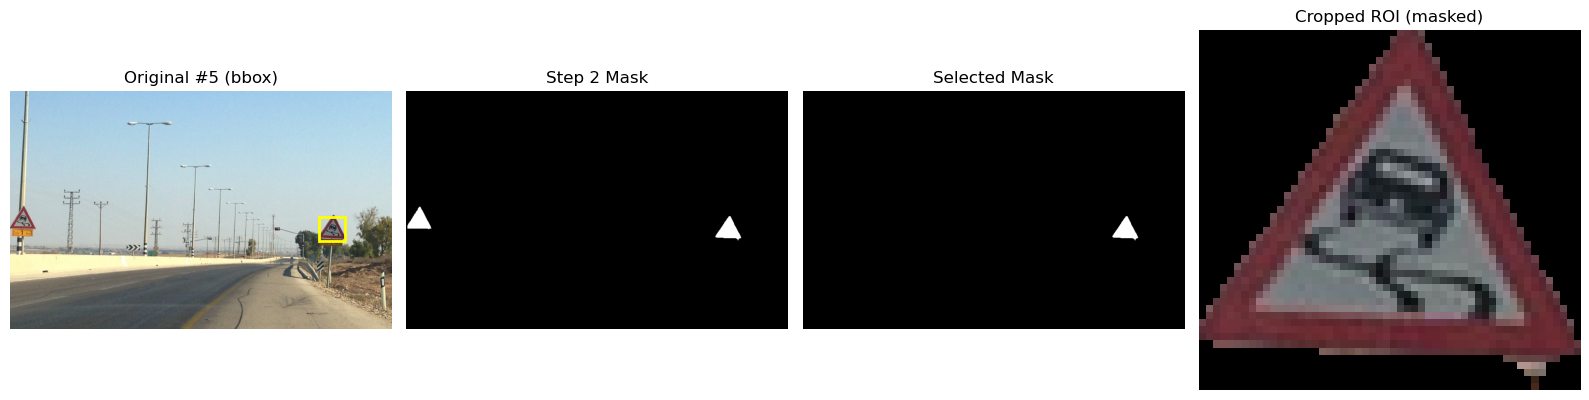

Image 6: shape=triangle area=2346 per=187 circ=0.843 bbox=(335, 829, 396, 898)


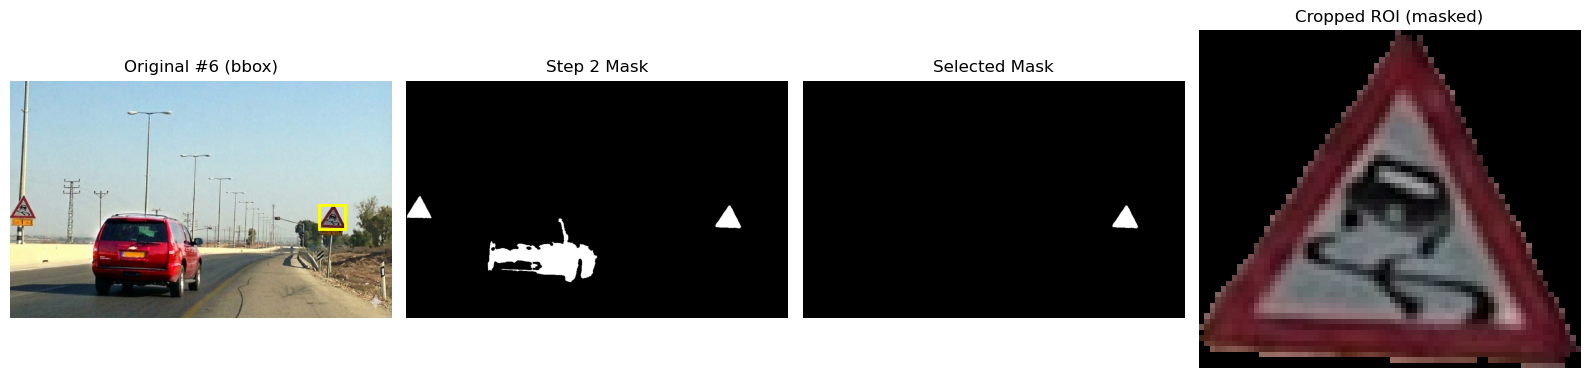

In [55]:
# ============================================================
# Step 3 — Connected Components + Shape Metrics + Best ROI selection
# UPDATED to use Union-Find CCL backend (HW-friendly)
#
# Dependencies (must exist from previous cell):
#   - uf_find
#   - ccl_pass1_unionfind
#
# Inputs:
#   - images        : list of RGB uint8 images (HxWx3)
#   - masks_step15  : list of binary uint8 masks (HxW, values {0,1})
#
# Outputs:
#   - best_masks    : list of best-component masks (HxW uint8) or None
#   - best_bboxes   : list of (ymin,xmin,ymax,xmax) inclusive or None
#   - best_infos    : list of dict stats per image
# ============================================================

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# ------------------------------------------------------------
# Metrics
# ------------------------------------------------------------

def circularity(area, perimeter, eps=1e-8):
    """
    Circularity = 4*pi*Area / Perimeter^2
    Range: (0..1] for ideal circle (continuous boundary).
    """
    if perimeter <= 0:
        return 0.0
    return float((4.0 * np.pi * area) / ((perimeter * perimeter) + eps))


# ------------------------------------------------------------
# Label-based stats (NO pixels list) — HW-friendly
# ------------------------------------------------------------

def compute_stats_from_labels(mask_u8, label_img, parent, next_label):
    """
    Compute per-root stats WITHOUT storing pixel lists:
      area[root]
      perimeter[root]   boundary-pixel count (4-neighborhood) like your old version
      bbox[root]        (ymin,xmin,ymax,xmax)
    """
    H, W = mask_u8.shape

    # Compress parent so parent[lbl] is the root (fast lookup in later scans)
    for lbl in range(1, next_label):
        parent[lbl] = uf_find(parent, int(lbl))

    area = np.zeros(next_label, dtype=np.uint32)
    per  = np.zeros(next_label, dtype=np.uint32)

    INF = 10**9
    ymin = np.full(next_label, INF, dtype=np.int32)
    xmin = np.full(next_label, INF, dtype=np.int32)
    ymax = np.full(next_label, -1, dtype=np.int32)
    xmax = np.full(next_label, -1, dtype=np.int32)

    # Single full scan: accumulate stats by root
    for y in range(H):
        for x in range(W):
            lbl = int(label_img[y, x])
            if lbl == 0:
                continue

            r = int(parent[lbl])

            # area
            area[r] += 1

            # bbox
            if y < ymin[r]: ymin[r] = y
            if x < xmin[r]: xmin[r] = x
            if y > ymax[r]: ymax[r] = y
            if x > xmax[r]: xmax[r] = x

            # perimeter approximation (same logic as your old perimeter_4_from_pixels):
            # boundary if any of 4-neighbors is background or out-of-bounds
            if y == 0 or mask_u8[y - 1, x] == 0:
                per[r] += 1
                continue
            if y == H - 1 or mask_u8[y + 1, x] == 0:
                per[r] += 1
                continue
            if x == 0 or mask_u8[y, x - 1] == 0:
                per[r] += 1
                continue
            if x == W - 1 or mask_u8[y, x + 1] == 0:
                per[r] += 1
                continue

    return area, per, ymin, xmin, ymax, xmax


def build_mask_for_root(label_img, parent, best_root):
    """
    Build a binary mask (HxW uint8) for a chosen root label.
    """
    H, W = label_img.shape
    out = np.zeros((H, W), dtype=np.uint8)
    br = int(best_root)

    for y in range(H):
        for x in range(W):
            lbl = int(label_img[y, x])
            if lbl == 0:
                continue
            if int(parent[lbl]) == br:
                out[y, x] = 1

    return out


# ------------------------------------------------------------
# Best component selection — UPDATED (no collect_components)
# ------------------------------------------------------------

def select_best_component_single(mask_u8,
                                 min_area=300,
                                 triangle_threshold=0.7,
                                 circle_threshold=0.9,
                                 max_labels=4096):
    """
    Label components using union-find CCL, compute stats via raster scans,
    and return the largest component that passes your circularity thresholds.
    """
    H, W = mask_u8.shape

    # Pass1 labeling + equivalences (4-connectivity)
    label_img, parent, next_label = ccl_pass1_unionfind(
        mask_u8, target_value=1, max_labels=max_labels
    )

    # Stats per root (HW-friendly scan)
    area, per, ymin, xmin, ymax, xmax = compute_stats_from_labels(
        mask_u8, label_img, parent, next_label
    )

    best_root = -1
    best_area = -1
    best_info = None

    # Iterate only roots
    for r in range(1, next_label):
        if int(parent[r]) != r:
            continue  # not a root

        a = int(area[r])
        if a < min_area:
            continue

        p = int(per[r])
        c = circularity(a, p)

        shape = None
        if triangle_threshold < c <= circle_threshold:
            shape = "triangle"
        elif c > circle_threshold:
            shape = "circle"
        else:
            continue

        if a > best_area:
            best_area = a
            best_root = r
            bbox = (int(ymin[r]), int(xmin[r]), int(ymax[r]), int(xmax[r]))
            best_info = {
                "root": int(r),
                "area": a,
                "perimeter": p,
                "circularity": float(c),
                "bbox": bbox,
                "shape": shape
            }

    if best_root < 0:
        return None, None, None

    best_mask = build_mask_for_root(label_img, parent, best_root)
    return best_mask, best_info["bbox"], best_info


def select_best_components_batch(masks_u8, **kwargs):
    """
    Batch wrapper over a list of masks.
    """
    best_masks = []
    best_bboxes = []
    best_infos = []

    for m in masks_u8:
        bm, bb, info = select_best_component_single(m, **kwargs)
        best_masks.append(bm)
        best_bboxes.append(bb)
        best_infos.append(info)

    return best_masks, best_bboxes, best_infos


# ------------------------------------------------------------
# ROI extraction + visualization (UNCHANGED)
# ------------------------------------------------------------

def crop_roi_with_mask(img_rgb_u8, best_mask_u8, bbox):
    ymin, xmin, ymax, xmax = bbox
    ymin = max(0, ymin); xmin = max(0, xmin)
    ymax = min(img_rgb_u8.shape[0] - 1, ymax)
    xmax = min(img_rgb_u8.shape[1] - 1, xmax)

    roi = img_rgb_u8[ymin:ymax+1, xmin:xmax+1].copy()

    if best_mask_u8 is not None:
        m = best_mask_u8[ymin:ymax+1, xmin:xmax+1]
        roi = roi * m[..., None].astype(roi.dtype)

    return roi


def show_step2_and_selection(images, masks_step2, best_masks, best_bboxes, best_infos, max_show=10):
    """
    Display per image:
      - Original + bbox overlay
      - Step 2 mask
      - Selected component mask
      - Cropped masked ROI
    """
    n = min(len(images), max_show)
    print(f"Showing {n} images...")

    for i in range(n):
        img = images[i]
        m2 = masks_step2[i]
        bm = best_masks[i]
        bb = best_bboxes[i]
        info = best_infos[i]

        if info is None:
            print(f"Image {i+1}: NO VALID COMPONENT (min_area/shape thresholds failed)")
        else:
            print(
                f"Image {i+1}: shape={info['shape']} area={info['area']} "
                f"per={info['perimeter']} circ={info['circularity']:.3f} bbox={info['bbox']}"
            )

        plt.figure(figsize=(16, 4))

        ax1 = plt.subplot(1, 4, 1)
        ax1.imshow(img)
        ax1.set_title(f"Original #{i+1} (bbox)")
        ax1.axis("off")
        if bb is not None:
            ymin, xmin, ymax, xmax = bb
            rect = patches.Rectangle(
                (xmin, ymin),
                (xmax - xmin + 1),
                (ymax - ymin + 1),
                linewidth=2,
                edgecolor="yellow",
                facecolor="none"
            )
            ax1.add_patch(rect)

        ax2 = plt.subplot(1, 4, 2)
        ax2.imshow(m2, cmap="gray", vmin=0, vmax=1)
        ax2.set_title("Step 2 Mask")
        ax2.axis("off")

        ax3 = plt.subplot(1, 4, 3)
        if bm is None:
            ax3.imshow(np.zeros_like(m2), cmap="gray", vmin=0, vmax=1)
            ax3.set_title("Selected Mask (none)")
        else:
            ax3.imshow(bm, cmap="gray", vmin=0, vmax=1)
            ax3.set_title("Selected Mask")
        ax3.axis("off")

        ax4 = plt.subplot(1, 4, 4)
        if bm is None or bb is None:
            ax4.imshow(np.zeros((32, 32, 3), dtype=np.uint8))
            ax4.set_title("Cropped ROI (none)")
        else:
            roi = crop_roi_with_mask(img, bm, bb)
            ax4.imshow(roi)
            ax4.set_title("Cropped ROI (masked)")
        ax4.axis("off")

        plt.tight_layout()
        plt.show()


# ------------------------------------------------------------
# RUN THIS BLOCK (after you already computed masks_step2)
# ------------------------------------------------------------

best_masks, best_bboxes, best_infos = select_best_components_batch(
    masks_step2,
    min_area=300,
    triangle_threshold=0.7,
    circle_threshold=0.9,
    max_labels=4096
)

show_step2_and_selection(
    images,
    masks_step2,
    best_masks,
    best_bboxes,
    best_infos,
    max_show=10
)


Loaded templates: ['1', '10', '11', '12', '13', '14', '2', '4', '6', '7', '8', '9']
Image 1: TOP3: 12(0.149), 8(0.288), 6(0.292) | best='12' SAD=0.149 => pred='12'
Image 2: TOP3: 4(0.182), 13(0.185), 1(0.190) | best='4' SAD=0.182 => pred='4'
Image 3: TOP3: 4(0.142), 10(0.143), 9(0.155) | best='4' SAD=0.142 => pred='4'
Image 4: TOP3: 11(0.120), 14(0.301), 12(0.317) | best='11' SAD=0.120 => pred='11'
Image 5: TOP3: 8(0.186), 6(0.187), 1(0.194) | best='8' SAD=0.186 => pred='8'
Image 6: TOP3: 6(0.167), 8(0.169), 1(0.174) | best='6' SAD=0.167 => pred='6'
Visualizing match quality for 6 ROIs...

ROI #1: best='12' SAD=0.1493, 2nd=0.2876, margin=0.1383 | pred=12 | best_scores[i]=0.1493


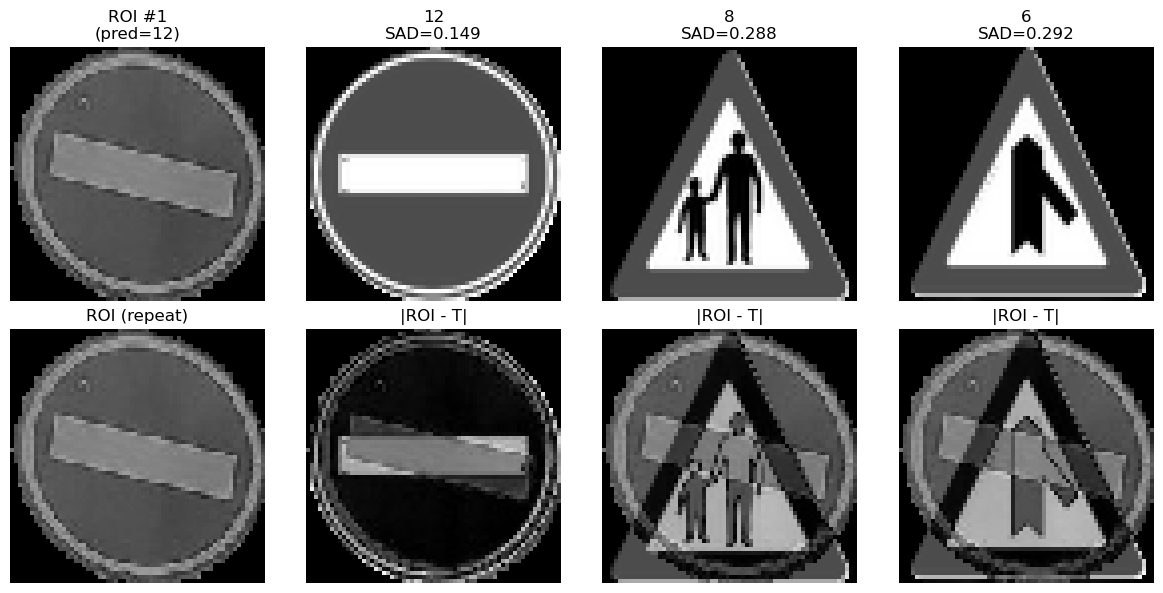

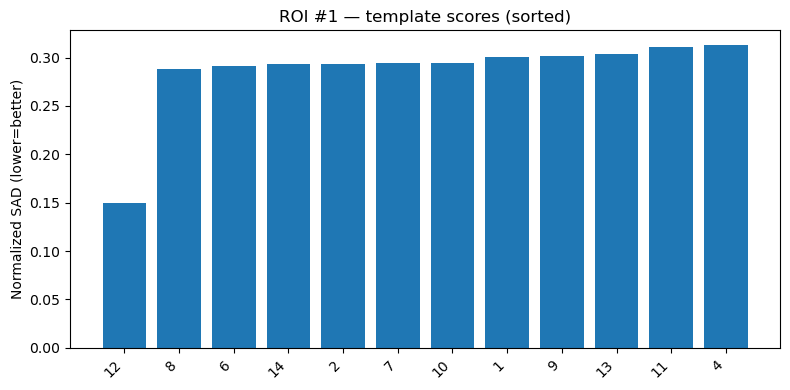


ROI #2: best='4' SAD=0.1820, 2nd=0.1849, margin=0.0029 | pred=4 | best_scores[i]=0.1820


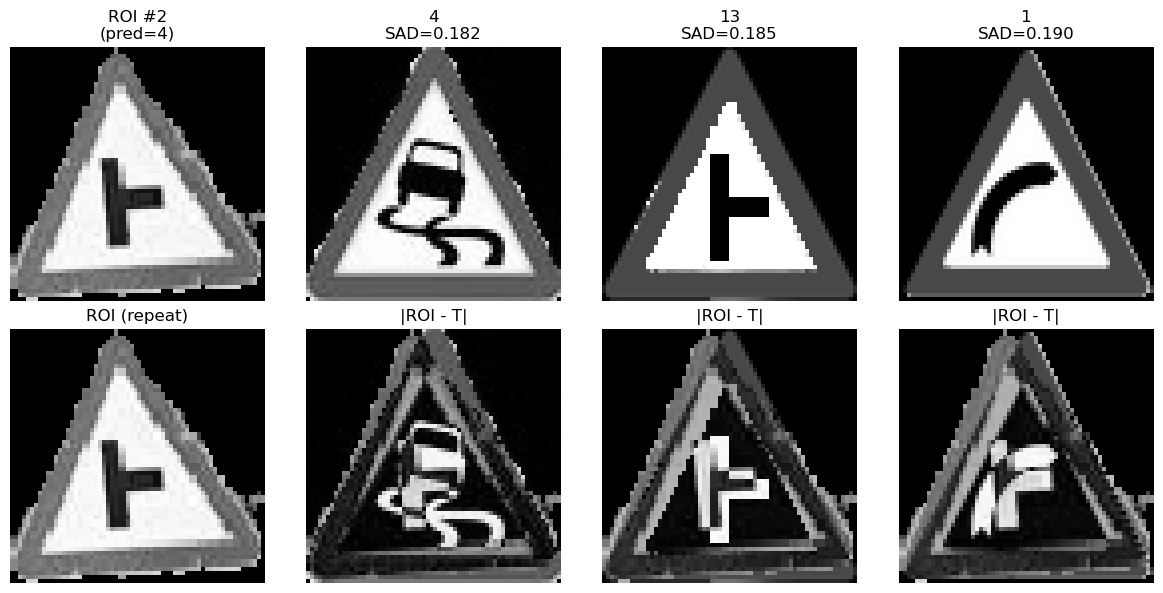

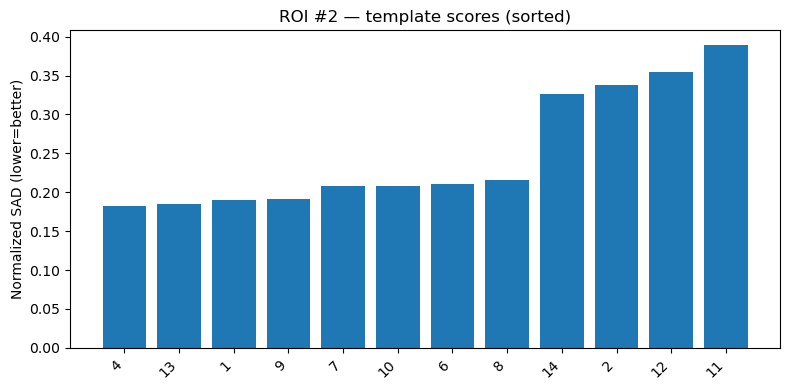


ROI #3: best='4' SAD=0.1418, 2nd=0.1431, margin=0.0013 | pred=4 | best_scores[i]=0.1418


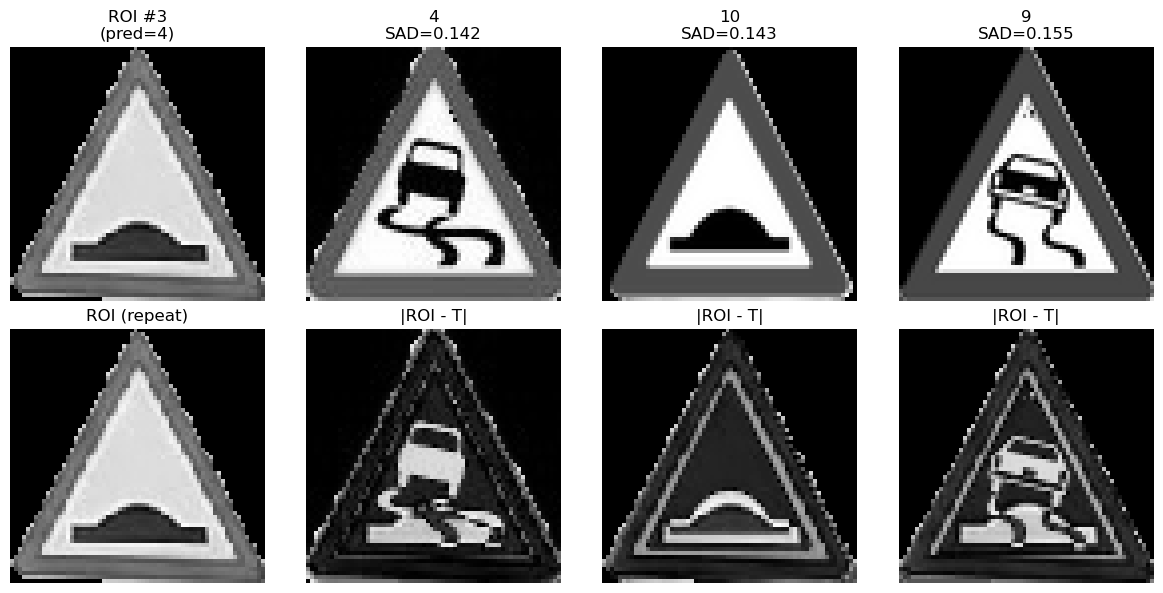

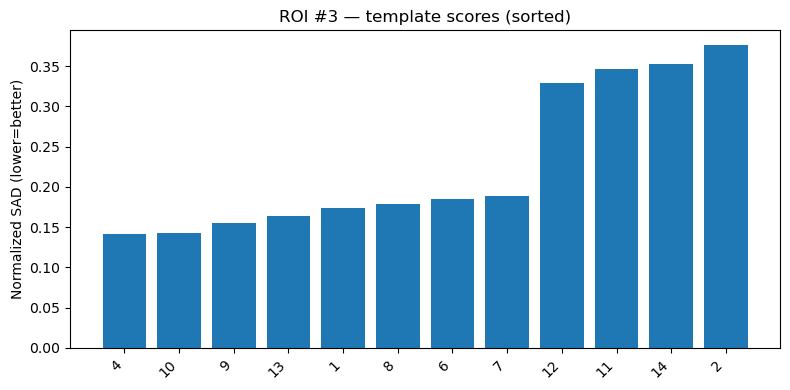


ROI #4: best='11' SAD=0.1204, 2nd=0.3007, margin=0.1803 | pred=11 | best_scores[i]=0.1204


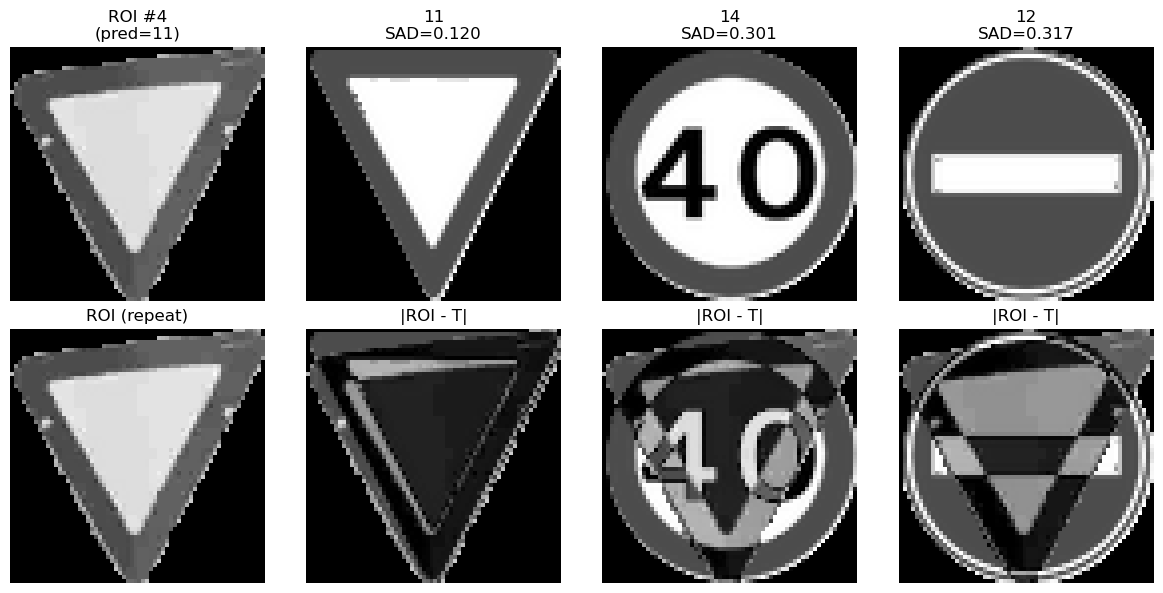

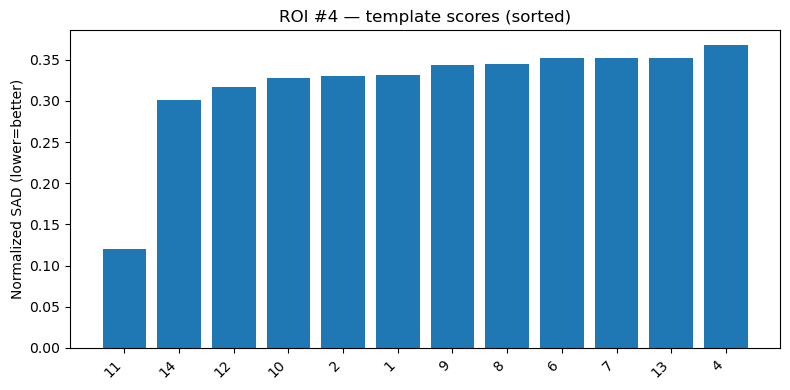


ROI #5: best='8' SAD=0.1857, 2nd=0.1866, margin=0.0009 | pred=8 | best_scores[i]=0.1857


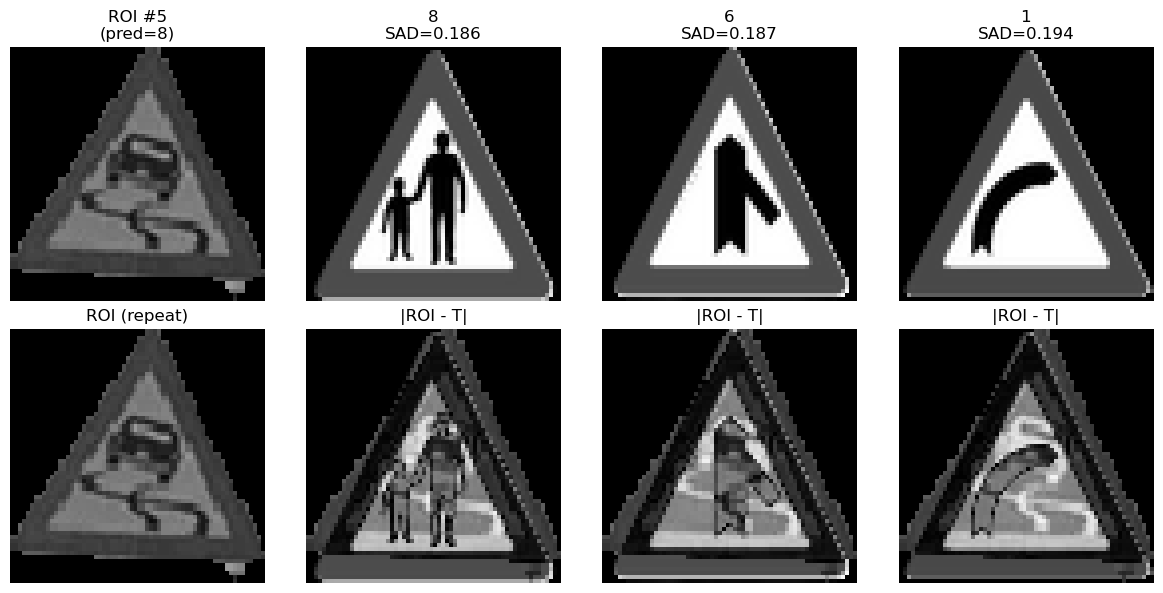

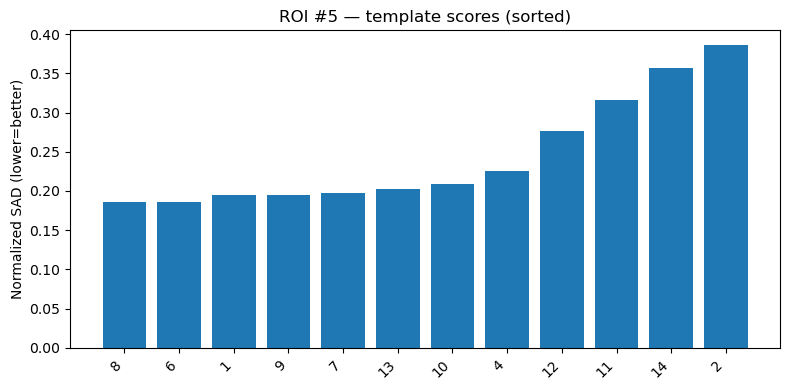


ROI #6: best='6' SAD=0.1668, 2nd=0.1690, margin=0.0022 | pred=6 | best_scores[i]=0.1668


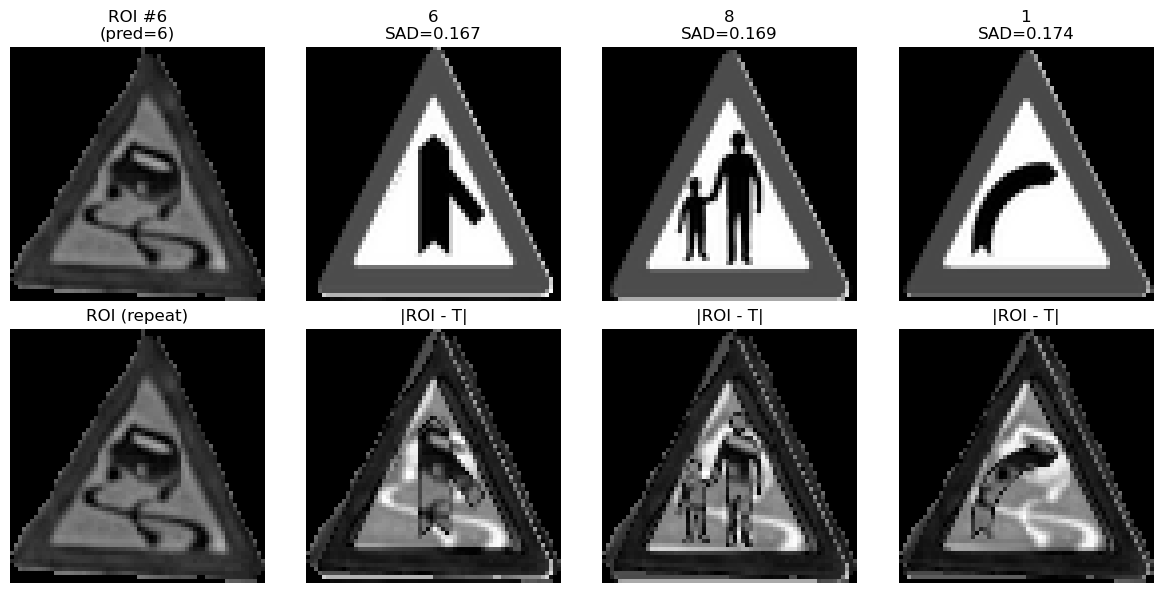

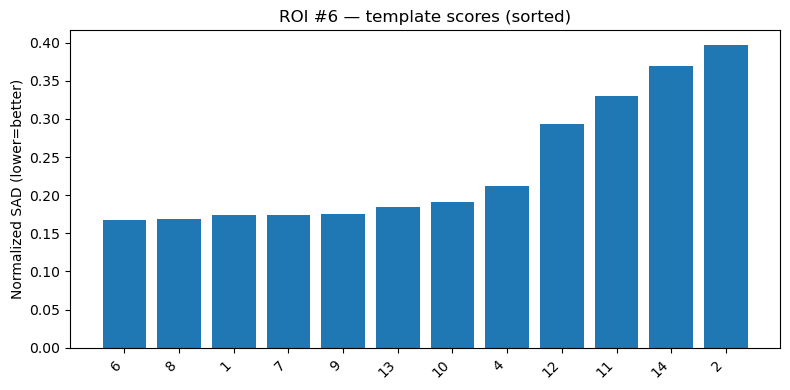


Predictions:
Image 1: pred=12 score=0.149
Image 2: pred=4 score=0.182
Image 3: pred=4 score=0.142
Image 4: pred=11 score=0.120
Image 5: pred=8 score=0.186
Image 6: pred=6 score=0.167
Showing 6 matches...


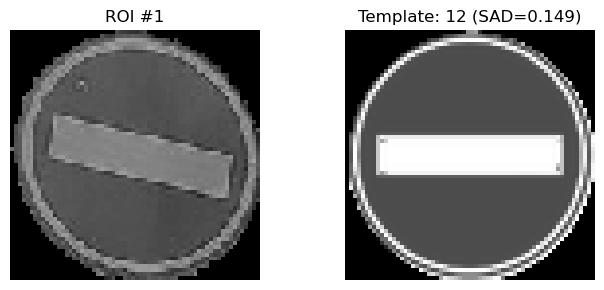

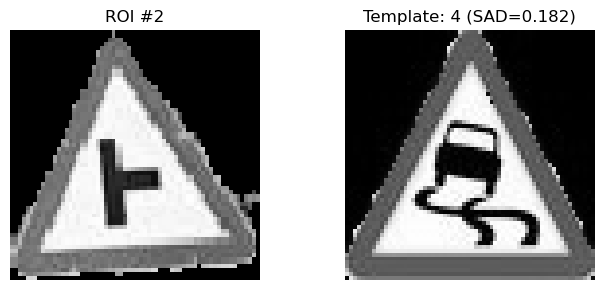

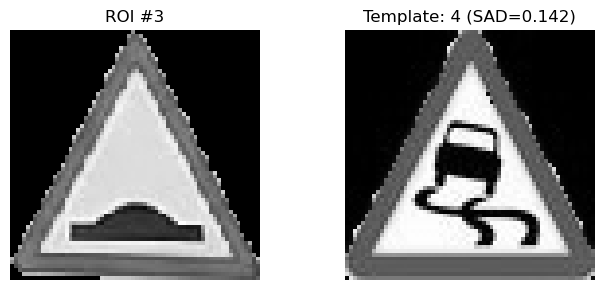

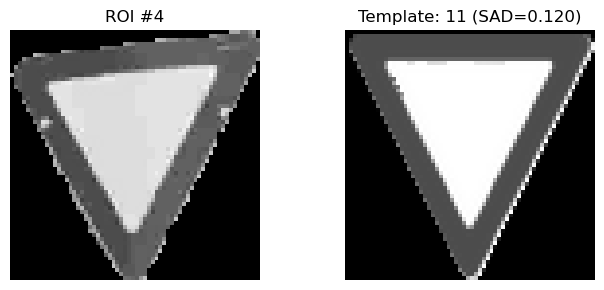

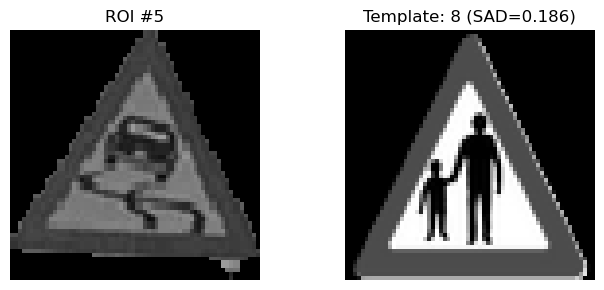

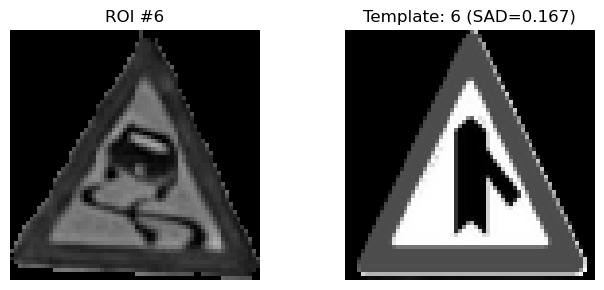

In [73]:
# ============================================================
# Step 4 — Resize ROI to fixed size (NN) & Template Matching (SAD)
# Sub-steps: 4a) Resize, 4b) Template matching
#
# Depends on existing variables from previous blocks:
#   - images        : list of RGB uint8 images (HxWx3)
#   - best_masks    : list of best component masks (HxW uint8) or None
#   - best_bboxes   : list of (ymin,xmin,ymax,xmax) inclusive or None
#   - crop_roi_with_mask(img, best_mask, bbox)  (from previous code)
#
# Produces:
#   - resized_rois_rgb : list of 64x64 RGB uint8 (or None)
#   - pred_labels      : list of predicted template labels (or "no_sign"/"unknown")
#   - best_scores      : list of normalized SAD scores (lower is better)
#
# Includes visualization at the end.
# ============================================================

import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

TARGET_H = 64
TARGET_W = 64
TEMPLATE_DIR = "Templates"

# ------------------------------------------------------------
# Low-level helpers: grayscale + nearest-neighbor resize
# ------------------------------------------------------------

def rgb_to_gray_u8(img_rgb_u8):
    """
    Convert RGB uint8 image to grayscale uint8 using integer approximation.
    Gray ~= 0.299R + 0.587G + 0.114B
    Implemented as: (77*R + 150*G + 29*B) >> 8
    """
    H, W, _ = img_rgb_u8.shape
    out = np.zeros((H, W), dtype=np.uint8)
    for y in range(H):
        for x in range(W):
            R = int(img_rgb_u8[y, x, 0])
            G = int(img_rgb_u8[y, x, 1])
            B = int(img_rgb_u8[y, x, 2])
            gray = (77 * R + 150 * G + 29 * B) >> 8
            if gray < 0: gray = 0
            if gray > 255: gray = 255
            out[y, x] = gray
    return out


def resize_nn_gray_u8(img_u8, out_h=TARGET_H, out_w=TARGET_W):
    """
    Nearest-neighbor resize for a single-channel uint8 image.
    """
    in_h, in_w = img_u8.shape
    out = np.zeros((out_h, out_w), dtype=np.uint8)

    for y in range(out_h):
        sy = (y * in_h) // out_h
        if sy >= in_h: sy = in_h - 1
        for x in range(out_w):
            sx = (x * in_w) // out_w
            if sx >= in_w: sx = in_w - 1
            out[y, x] = img_u8[sy, sx]

    return out


def resize_nn_rgb_u8(img_rgb_u8, out_h=TARGET_H, out_w=TARGET_W):
    """
    Nearest-neighbor resize for an RGB uint8 image.
    """
    in_h, in_w, _ = img_rgb_u8.shape
    out = np.zeros((out_h, out_w, 3), dtype=np.uint8)

    for y in range(out_h):
        sy = (y * in_h) // out_h
        if sy >= in_h: sy = in_h - 1
        for x in range(out_w):
            sx = (x * in_w) // out_w
            if sx >= in_w: sx = in_w - 1
            out[y, x, 0] = img_rgb_u8[sy, sx, 0]
            out[y, x, 1] = img_rgb_u8[sy, sx, 1]
            out[y, x, 2] = img_rgb_u8[sy, sx, 2]

    return out


# ------------------------------------------------------------
# Step 4a: ROI crop + mask + resize (batch)
# ------------------------------------------------------------

def build_resized_rois_batch(images, best_masks, best_bboxes, out_h=TARGET_H, out_w=TARGET_W):
    """
    For each image:
      - If bbox/mask missing => None
      - Crop ROI from original RGB
      - Apply component mask inside ROI
      - Resize to fixed out_h x out_w (NN)
    Returns list of resized RGB rois (or None).
    """
    resized_rois = []

    for i in range(len(images)):
        img = images[i]
        bm = best_masks[i]
        bb = best_bboxes[i]

        if bm is None or bb is None:
            resized_rois.append(None)
            continue

        roi = crop_roi_with_mask(img, bm, bb)          # cropped + masked (RGB)
        roi64 = resize_nn_rgb_u8(roi, out_h, out_w)    # 64x64 RGB
        resized_rois.append(roi64)

    return resized_rois


# ------------------------------------------------------------
# Step 4b: BASIC Template Matching (SAD on grayscale)
# ------------------------------------------------------------

def load_templates_gray_u8(template_dir=TEMPLATE_DIR, out_h=TARGET_H, out_w=TARGET_W):
    """
    Load templates from a folder, convert to grayscale uint8, resize to target size (NN).
    Returns dict: label -> (out_h,out_w) uint8
    """
    if not os.path.isdir(template_dir):
        raise FileNotFoundError(f"Folder '{template_dir}' not found next to the notebook.")

    valid_ext = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")
    templates = {}

    for fname in sorted(os.listdir(template_dir)):
        if not fname.lower().endswith(valid_ext):
            continue

        label = os.path.splitext(fname)[0]
        img = io.imread(os.path.join(template_dir, fname))

        # Ensure RGB for grayscale conversion
        if img.ndim == 2:
            img_rgb = np.stack([img, img, img], axis=2).astype(np.uint8)
        else:
            if img.shape[2] == 4:
                img = img[:, :, :3]
            img_rgb = img.astype(np.uint8)

        g = rgb_to_gray_u8(img_rgb)
        g64 = resize_nn_gray_u8(g, out_h, out_w)
        templates[label] = g64

    if len(templates) == 0:
        raise RuntimeError(f"No templates found in '{template_dir}'.")

    print("Loaded templates:", list(templates.keys()))
    return templates


def sad_score_norm_u8(a_u8, b_u8):
    """
    Normalized SAD (sum of absolute differences) for same-size uint8 arrays.
    Returns score in [0..1], lower is better.
      score = sum(|a-b|) / (255 * H * W)
    """
    H, W = a_u8.shape
    s = 0
    for y in range(H):
        for x in range(W):
            da = int(a_u8[y, x]) - int(b_u8[y, x])
            if da < 0: da = -da
            s += da
    denom = 255.0 * H * W
    return float(s) / denom if denom > 0 else 1.0


def match_rois_to_templates(resized_rois_rgb, templates_gray_u8, match_threshold=0.30, top_k=3):
    """
    For each ROI:
      - If None => "no_sign"
      - Convert ROI to gray, compute SAD vs each template
      - Print TOP-K (lowest SAD = best)
      - Pick minimal SAD
      - If best SAD <= threshold => predicted label else "unknown"

    Returns:
      pred_labels, best_scores, best_template_labels, topk_lists
    where topk_lists[i] is a list of (label, score) pairs (sorted ascending) for ROI i.
    """
    pred_labels = []
    best_scores = []
    best_template_labels = []
    topk_lists = []

    labels = list(templates_gray_u8.keys())

    for i, roi_rgb in enumerate(resized_rois_rgb, start=1):
        if roi_rgb is None:
            pred_labels.append("no_sign")
            best_scores.append(None)
            best_template_labels.append(None)
            topk_lists.append([])
            print(f"Image {i}: ROI=None => pred='no_sign'")
            continue

        roi_g = rgb_to_gray_u8(roi_rgb)

        # Compute all scores
        scores = []
        for lab in labels:
            sc = sad_score_norm_u8(roi_g, templates_gray_u8[lab])
            scores.append((lab, sc))

        # Sort by score (ascending)
        scores.sort(key=lambda t: t[1])

        # Take top-k
        k = top_k if top_k > 0 else 1
        topk = scores[:k]
        topk_lists.append(topk)

        # Best
        best_lab, best_sc = topk[0]
        pred = best_lab if best_sc <= match_threshold else "unknown"

        pred_labels.append(pred)
        best_scores.append(best_sc)
        best_template_labels.append(best_lab)

        # Print TOP-K line
        # Example: Image 1: TOP3: stop(0.123), speed50(0.141), yield(0.155) | best='stop' 0.123 => pred='stop'
        topk_str = ", ".join([f"{lab}({sc:.3f})" for lab, sc in topk])
        print(f"Image {i}: TOP{len(topk)}: {topk_str} | best='{best_lab}' SAD={best_sc:.3f} => pred='{pred}'")

    return pred_labels, best_scores, best_template_labels, topk_lists



# ------------------------------------------------------------
# Visualization: resized ROI vs best template
# ------------------------------------------------------------

def show_template_matching(resized_rois_rgb, templates_gray_u8, pred_labels, best_scores, max_show=10):
    """
    Show ROI (gray) vs predicted template (gray).
    """
    n = min(len(resized_rois_rgb), max_show)
    print(f"Showing {n} matches...")

    for i in range(n):
        roi_rgb = resized_rois_rgb[i]
        pred = pred_labels[i]
        sc = best_scores[i]

        if roi_rgb is None:
            continue
        if pred in ("no_sign", "unknown"):
            # Still show ROI alone (optional)
            plt.figure(figsize=(4, 3))
            plt.imshow(rgb_to_gray_u8(roi_rgb), cmap="gray", vmin=0, vmax=255)
            plt.title(f"ROI #{i+1} — pred={pred}")
            plt.axis("off")
            plt.show()
            continue

        roi_g = rgb_to_gray_u8(roi_rgb)
        tmpl_g = templates_gray_u8[pred]

        plt.figure(figsize=(7, 3))

        plt.subplot(1, 2, 1)
        plt.imshow(roi_g, cmap="gray", vmin=0, vmax=255)
        plt.title(f"ROI #{i+1}")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(tmpl_g, cmap="gray", vmin=0, vmax=255)
        plt.title(f"Template: {pred} (SAD={sc:.3f})")
        plt.axis("off")

        plt.tight_layout()
        plt.show()


# ------------------------------------------------------------
# RUN
# ------------------------------------------------------------

# Step 4a (Resize)
resized_rois_rgb = build_resized_rois_batch(images, best_masks, best_bboxes, out_h=TARGET_H, out_w=TARGET_W)

# Step 4b (Template Matching)
templates_gray_u8 = load_templates_gray_u8(TEMPLATE_DIR, out_h=TARGET_H, out_w=TARGET_W)
pred_labels, best_scores, best_template_labels, top3_lists = match_rois_to_templates(
    resized_rois_rgb,
    templates_gray_u8,
    match_threshold=0.30,
    top_k=3
)

# ============================================================
# Extra Visualization — ROI vs TOP-K templates + diff maps + score bars
# Depends on existing helpers:
#   - rgb_to_gray_u8
#   - sad_score_norm_u8
# And existing outputs:
#   - resized_rois_rgb, templates_gray_u8
#   - pred_labels, best_scores, top3_lists  (or topk_lists)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

def _u8_absdiff(a_u8, b_u8):
    """Absolute difference map in uint8 (0..255)."""
    d = a_u8.astype(np.int16) - b_u8.astype(np.int16)
    d = np.abs(d)
    return np.clip(d, 0, 255).astype(np.uint8)

def visualize_match_quality(
    resized_rois_rgb,
    templates_gray_u8,
    topk_lists,
    pred_labels=None,
    best_scores=None,
    max_show=10,
    top_k=None,
    show_all_scores_bar=True,
    top_n_bar=None
):
    """
    For each ROI (up to max_show):
      Figure 1: ROI + TOP-K templates + abs-diff maps
      Figure 2 (optional): bar plot of template scores (sorted)

    top_n_bar: if None -> show all templates in bar plot, else only first N (best N after sorting).
    """

    labels = list(templates_gray_u8.keys())
    n = min(len(resized_rois_rgb), max_show)

    print(f"Visualizing match quality for {n} ROIs...")

    for i in range(n):
        roi_rgb = resized_rois_rgb[i]
        if roi_rgb is None:
            print(f"ROI #{i+1}: None (skipping)")
            continue

        roi_g = rgb_to_gray_u8(roi_rgb)

        # Use provided topk list; if missing, compute on the fly
        if topk_lists is None or len(topk_lists) <= i or len(topk_lists[i]) == 0:
            scores = [(lab, sad_score_norm_u8(roi_g, templates_gray_u8[lab])) for lab in labels]
            scores.sort(key=lambda t: t[1])
            k_eff = 3 if top_k is None else max(1, int(top_k))
            topk = scores[:k_eff]
        else:
            topk = topk_lists[i]
            if top_k is not None:
                topk = topk[:max(1, int(top_k))]

        # Confidence-ish numbers
        best_lab, best_sc = topk[0]
        second_sc = topk[1][1] if len(topk) >= 2 else None
        margin = (second_sc - best_sc) if second_sc is not None else None

        pred = None if pred_labels is None else pred_labels[i]
        sc_print = None if best_scores is None else best_scores[i]

        print(f"\nROI #{i+1}: best='{best_lab}' SAD={best_sc:.4f}"
              + (f", 2nd={second_sc:.4f}, margin={margin:.4f}" if margin is not None else "")
              + (f" | pred={pred}" if pred is not None else "")
              + (f" | best_scores[i]={sc_print:.4f}" if sc_print is not None else "")
        )

        # -----------------------------
        # Figure 1: ROI vs TOP-K + diff
        # Layout:
        #   Row 0: ROI | T1 | T2 | ...
        #   Row 1: ROI | D1 | D2 | ...   (D = |ROI-Template|)
        # -----------------------------
        k_eff = len(topk)
        fig, axes = plt.subplots(2, k_eff + 1, figsize=(3.0 * (k_eff + 1), 6.0))

        # ROI column
        axes[0, 0].imshow(roi_g, cmap="gray", vmin=0, vmax=255)
        axes[0, 0].set_title(f"ROI #{i+1}\n(pred={pred})" if pred is not None else f"ROI #{i+1}")
        axes[0, 0].axis("off")

        axes[1, 0].imshow(roi_g, cmap="gray", vmin=0, vmax=255)
        axes[1, 0].set_title("ROI (repeat)")
        axes[1, 0].axis("off")

        # TOP-K columns
        for j, (lab, sc) in enumerate(topk, start=1):
            tmpl_g = templates_gray_u8[lab]
            diff = _u8_absdiff(roi_g, tmpl_g)

            axes[0, j].imshow(tmpl_g, cmap="gray", vmin=0, vmax=255)
            axes[0, j].set_title(f"{lab}\nSAD={sc:.3f}")
            axes[0, j].axis("off")

            axes[1, j].imshow(diff, cmap="gray", vmin=0, vmax=255)
            axes[1, j].set_title("|ROI - T|")
            axes[1, j].axis("off")

        plt.tight_layout()
        plt.show()

        # ------------------------------------------
        # Figure 2: Bar plot of (sorted) SAD scores
        # Shows whether the best is clearly separated
        # ------------------------------------------
        if show_all_scores_bar:
            scores_all = [(lab, sad_score_norm_u8(roi_g, templates_gray_u8[lab])) for lab in labels]
            scores_all.sort(key=lambda t: t[1])

            if top_n_bar is not None:
                top_n = max(1, int(top_n_bar))
                scores_all = scores_all[:top_n]

            labs = [t[0] for t in scores_all]
            vals = [t[1] for t in scores_all]

            plt.figure(figsize=(max(8, 0.55 * len(labs)), 4))
            plt.bar(range(len(labs)), vals)
            plt.xticks(range(len(labs)), labs, rotation=45, ha="right")
            plt.ylabel("Normalized SAD (lower=better)")
            plt.title(f"ROI #{i+1} — template scores (sorted)")
            plt.tight_layout()
            plt.show()


# -----------------------------
# RUN the visualization
# -----------------------------
# Example: show TOP-3 + full score bars for first 10 ROIs
visualize_match_quality(
    resized_rois_rgb=resized_rois_rgb,
    templates_gray_u8=templates_gray_u8,
    topk_lists=top3_lists,        # your existing top-k output
    pred_labels=pred_labels,
    best_scores=best_scores,
    max_show=10,
    top_k=3,
    show_all_scores_bar=True,
    top_n_bar=None                # or set e.g. 12 to avoid huge bars
)



# Print summary
print("\nPredictions:")
for i in range(len(pred_labels)):
    sc = best_scores[i]
    sc_str = "None" if sc is None else f"{sc:.3f}"
    print(f"Image {i+1}: pred={pred_labels[i]} score={sc_str}")

# Visualize
show_template_matching(resized_rois_rgb, templates_gray_u8, pred_labels, best_scores, max_show=10)